### Es 1
Hai a disposizione un file `data.csv` contenente dati mensili di passeggeri con due colonne:

- `date`: data in formato `YYYY-MM` (mese/anno)
- `passengers`: numero di passeggeri per quel mese


Costruisci un modello di **regressione polinomiale** che approssima l’andamento del numero di passeggeri nel tempo.

1. Carica il dataset.
2. Convertilo in un formato numerico utilizzando una colonna `mese_numerico` che conti i mesi a partire da gennaio 1949.
3. Applica una regressione polinomiale (grado a tua scelta).
4. Calcola l’RMSE tra i valori reali e quelli predetti.
5. Visualizza i dati reali e la curva stimata con Plotly.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

In [2]:
#1
df = pd.read_csv('data.csv')
df.head(5)

,date,passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [3]:
#2
df['mese_numerico'] = range(1, len(df) + 1)

print(df.isnull().sum()) #noto che c'è un NA da rimuovere
df.dropna(inplace=True)
print(df.isnull().sum())

date             0
passengers       1
mese_numerico    0
dtype: int64
date             0
passengers       0
mese_numerico    0
dtype: int64


In [4]:
#3
grado = 2
x = df["mese_numerico"]
y = df["passengers"]

coefficienti = np.polyfit(x,y,grado)
y_predette = np.polyval(coefficienti, x)


In [5]:
#4
rmse = np.sqrt(( np.mean( (y-y_predette)**2 ) ))

#srmse = math.sqrt(mean_squared_error(y, y_predette))
rmse

np.float64(45.23725439143307)

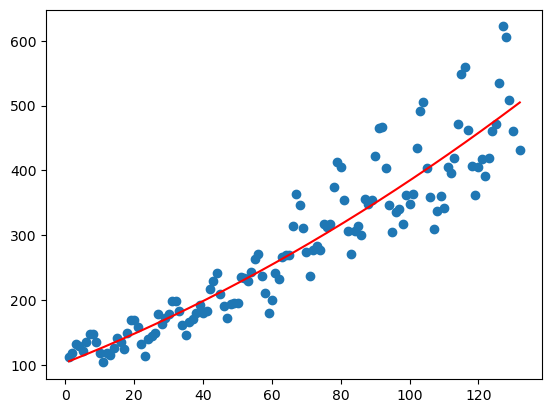

In [6]:
plt.scatter(x,y)
plt.plot(x, y_predette, color = 'red')
plt.show()

In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=y,
    mode='markers',
    name='Dati reali',
    marker=dict(color='blue', size=6)
))

fig.add_trace(go.Scatter(
    x=x,
    y=y_predette,
    mode='lines',
    name=f'Regressione polinomiale (grado {grado})',
    line=dict(color='red', width=3)
))

fig.update_layout(
    title=f'Regressione Polinomiale - Numero di Passeggeri nel Tempo',
    xaxis_title='Mese Numerico (da Gennaio 1949)',
    yaxis_title='Numero di Passeggeri',
    showlegend=True,
    width=800,
    height=500
)

fig.show()

### Es2. 
Costruisci una web app con Dash che permette all’utente di scegliere il grado del polinomio per adattare un modello di regressione ai dati non lineari e vedere il risultato aggiornarsi dinamicamente.


1. Genera 100 punti x tra -3 e 3.

2. Calcola ad esempio y = x³ - x + rumore.

3. Costruisci un'interfaccia Dash con:
    - uno slider per scegliere il grado del polinomio (1–10),
    - un grafico Plotly che mostra i dati e la curva stimata.

4. Usa PolynomialFeatures + LinearRegression da scikit-learn per stimare la curva

In [14]:
import dash
from dash import dcc, html, Input, Output

In [15]:
#1
np.random.seed(42)  # Per risultati riproducibili
x = np.linspace(-3, 3, 100)

In [16]:
# 2. Calcola y = x³ - x + rumore
noise = np.random.normal(0, 0.3, 100)
y = x**3 - x + noise

In [17]:
#3
app = dash.Dash(__name__)


app.layout = html.Div([
    html.H1("Regressione Polinomiale Interattiva", 
            style={'text-align': 'center', 'color': '#2c3e50'}),
    
    html.Div([
        html.Label("Scegli il grado del polinomio:", 
                  style={'font-size': '16px', 'font-weight': 'bold'}),
        dcc.Slider(
            id='grado-slider',
            min=1,
            max=10,
            step=1,
            value=3,
            marks={i: str(i) for i in range(1, 11)},
            tooltip={"placement": "bottom", "always_visible": True}
        ),
        html.Div(id='rmse-output', 
                style={'margin-top': '20px', 'font-size': '14px', 'color': '#34495e'})
    ], style={'margin': '20px', 'padding': '20px', 'background-color': '#f8f9fa', 'border-radius': '10px'}),
    
    dcc.Graph(id='grafico-regressione'),
    
    html.Div([
        html.H3("Informazioni sui Dati"),
        html.P("• Funzione originale: y = x³ - x + rumore"),
        html.P("• 100 punti generati tra x = -3 e x = 3"),
        html.P("• Usa lo slider per vedere come cambia l'adattamento al variare del grado del polinomio")
    ], style={'margin': '20px', 'padding': '20px', 'background-color': '#e8f4f8', 'border-radius': '10px'})
])


In [18]:
#4
@app.callback(
    [Output('grafico-regressione', 'figure'),
     Output('rmse-output', 'children')],
    [Input('grado-slider', 'value')]
)
def aggiorna_grafico(grado):
    # Prepara i dati per sklearn
    X = x.reshape(-1, 1)
    
    # Crea le features polinomiali
    poly_features = PolynomialFeatures(degree=grado)
    X_poly = poly_features.fit_transform(X)
    
    # Addestra il modello
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Predizioni
    y_pred = model.predict(X_poly)
    
    rmse = math.sqrt(mean_squared_error(y, y_pred))
    x_smooth = np.linspace(-3, 3, 300)
    X_smooth = x_smooth.reshape(-1, 1)
    X_smooth_poly = poly_features.transform(X_smooth)
    y_smooth_pred = model.predict(X_smooth_poly)
    
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name='Dati originali',
        marker=dict(color='blue', size=8, opacity=0.7)
    ))
    fig.add_trace(go.Scatter(
        x=x_smooth,
        y=y_smooth_pred,
        mode='lines',
        name=f'Polinomio grado {grado}',
        line=dict(color='red', width=3)
    ))
    y_teorica = x**3 - x
    fig.add_trace(go.Scatter(
        x=x,
        y=y_teorica,
        mode='lines',
        name='Funzione teorica (x³ - x)',
        line=dict(color='green', width=2, dash='dash'),
        opacity=0.7
    ))
    fig.update_layout(
        title=f'Regressione Polinomiale - Grado {grado}',
        xaxis_title='x',
        yaxis_title='y',
        showlegend=True,
        width=800,
        height=600,
        template='plotly_white'
    )
    rmse_msg = f"RMSE: {rmse:.4f}"
    
    return fig, rmse_msg


In [19]:
#avvio applicazione
if __name__ == '__main__':
    print("Avvio dell'applicazione Dash...")
    print("Apri il browser e vai a: http://127.0.0.1:8050")
    app.run_server(debug=True)

Avvio dell'applicazione Dash...
Apri il browser e vai a: http://127.0.0.1:8050
